# Fake News Classifier
The dataset can be downloaded from: https://www.kaggle.com/c/fake-news/data

In [143]:
import pandas as pd
import numpy as np
import nltk
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Define functions to calculate accuracy and plot confusion matrix to evaluate model performance. 

In [109]:
## function for calculating accuracy score
def accuracy(y_test, y_pred, model_name=''):
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of " + model_name + ":", acc)

In [115]:
## function for calculating and plotting confusion matrix
def con_mat(df_cm, 
            title='Confusion Matrix', 
            colors='Blues', 
            percentage=False):
    if (percentage==False):
        # plot confusion matrix as a heatmap
        plt.figure(figsize=(10,10))
        heat_map_predictions=sns.heatmap(df_cm, annot=True, cmap=colors, fmt='g')
        heat_map_predictions.yaxis.set_ticklabels(heat_map_predictions.yaxis.get_ticklabels(), rotation=0, ha='right')
        heat_map_predictions.xaxis.set_ticklabels(heat_map_predictions.xaxis.get_ticklabels(), rotation=45, ha='right')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(title)
        plt.show()
    else:
        # display the results as percentages of the total number
        df_cm = df_cm.astype('float')/df_cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10,10))
        heat_map_predictions=sns.heatmap(df_cm, annot=True, cmap=colors, fmt='g')
        heat_map_predictions.yaxis.set_ticklabels(heat_map_predictions.yaxis.get_ticklabels(), rotation=0, ha='right')
        heat_map_predictions.xaxis.set_ticklabels(heat_map_predictions.xaxis.get_ticklabels(), rotation=45, ha='right')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(title + "(%)")
        plt.show()

### Data Preprocessing
The data is first read into a pandas dataframe.

In [69]:
## read the training data into a pandas dataframe
df = pd.read_csv('fake-news/train.csv')

In [70]:
print(df.shape)
df.head()

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Missing Values are checked with the *isna()* method and dropped. A resetting of the index is done post the deletion of missing values. This step is important during subsequent text preprocessing stages. 

In [71]:
## check for missing values
df.isna().sum().sum()
# delete rows with missing values
df = df.dropna()
# print new shape
print(df.shape)
# reset index post missing values deletion
df.reset_index(inplace=True)
df.head()

(18285, 5)


,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


The next step is the creation of independent and dependent features. For our independent feature, we will be concatenating the title and author fields into a messages column. The dependent feature is our label column, stored in y.

In [72]:
## create independent and dependent features 
# combining the title and author data field as independent feature
messages = df['title'] + ' ' + df['author']
y = df.iloc[:,-1]

Class imbalance can greatly impact model performance. Typically, models can become biased towards more frequently occuring classes. The counts for each class are plotted with a bar chart. The distribution, post compensating for the missing values, is fairly balanced. 

Real 10361
Fake 7924


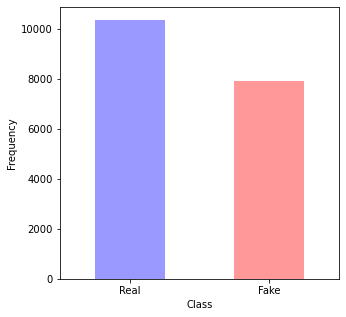

In [73]:
## check for class imbalance
count_classes = pd.value_counts(y, sort=True)
print("Real", count_classes[0])
print("Fake", count_classes[1])
LABELS = ['Real', 'Fake']
plt.figure(figsize=(5,5))
count_classes.plot(kind='bar', rot=0, color=['blue', 'red'], alpha=0.4)
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Text Preprocessing
NLP models require additional preprocessing due to the text data. This typically involves techniques like stemming, lemmatization, removal of stop words and tokenization procedures. In the following cell, a stemming object is created. This shortens the given words into their base form, often leading to forms not understandable in the context of daily language. For example, *history* and *historical* would be stemmed to a root form, such as 'histori'. Removal of the derivational and inflectional affixes from words allows the machine to process them in their most basic form, aiding in information retrieval.

A for loop is used to read through all the messages. In the first step, all characters except for alphabets are removed. The sentences are then converted to lowercase. This makes sure the model does not give importance to words in uppercase. The sentence is then split into a list of words. Finally, the stemming process is done on all words except stopwords. Stop words are a set of commonly used words in a language. For the English language, these would be 'a', 'the', 'their' etc. The words are converted back to a sentence, and appended to a list for later use. 

In [74]:
## text cleaning and preprocessing
# create a PorterStemmer object
sm = PorterStemmer()
corpus = []
for i in range(len(messages)):
    # remove characters or numbers apart from alphabets
    clean = re.sub('[^a-zA-Z]', ' ', messages[i])
    # put everything in lowercase
    clean = clean.lower()
    # split the sentences to a list of words to apply stemming/lemmatization
    clean = clean.split()
    # apply stemming
    clean = [sm.stem(word) for word in clean if not word in stopwords.words('english')]
    # join the words again to form a string
    clean = ' '.join(clean)
    # append to list
    corpus.append(clean)

The final list that will be supplied to our bag-of-words model is a list of strings and can be seen below.

In [75]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet darrel lucu',
 'flynn hillari clinton big woman campu breitbart daniel j flynn',
 'truth might get fire consortiumnew com',
 'civilian kill singl us airstrik identifi jessica purkiss',
 'iranian woman jail fiction unpublish stori woman stone death adulteri howard portnoy',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart daniel nussbaum',
 'beno hamon win french socialist parti presidenti nomin new york time alissa j rubin',
 'back channel plan ukrain russia courtesi trump associ new york time megan twohey scott shane',
 'obama organ action partner soro link indivis disrupt trump agenda aaron klein',
 'bbc comedi sketch real housew isi caus outrag chri tomlinson',
 'russian research discov secret nazi militari base treasur hunter arctic photo amando flavio',
 'us offici see link trump russia jason ditz',
 'ye paid govern troll social media blog forum websit anotheranni',
 'major

A bag-of-words model creates a bag out of all the words in the text. The order, structure or grammar of the sentences in the text is not important for a BOW. It only cares for multiplicity, or frequency of occurence of a particular word. Therefore, each word is given a score based on the number of times it has occured.

In [76]:
## create a bag of words model
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(corpus).toarray()

### Model Creation
The data is divided into training and test data, using a 80-20 ratio and keeping a random state of 0.

In [77]:
## perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In this notebook, we will be comparing several classifiers. The first of these is a Naive Bayes Classifier. The NB performs quite well, averaging an accuracy of 96%. However, a closer look at the confusion matrix suggests that the false positives are slightly higher (instances where a fake news is predicted as real). This can be problematic and misleading in a real scenario. Could we do better?

In [104]:
## fit a Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

In [110]:
## evaluate model using accuracy
accuracy(y_test, y_pred, model_name='Bag of Words with Naive Bayes Classifier')

Accuracy of Bag of Words with Naive Bayes Classifier: 0.9693738036642057


In [111]:
## evaluate using confusion matrix
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# convert to numpy matrix
val = np.mat(cm)
# class labels (1: FAKE, 0: REAL)
# create a dataframe from the 
df_cm=pd.DataFrame(val, index=LABELS, columns=LABELS)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       Real  Fake
Real  2020    20
Fake    92  1525


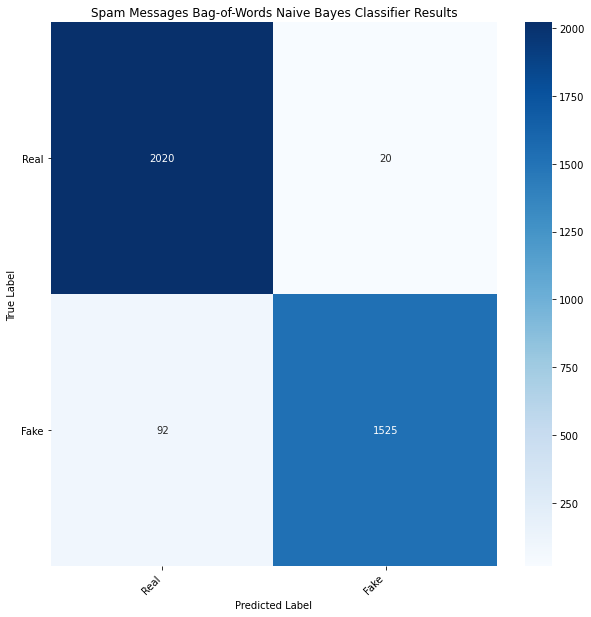

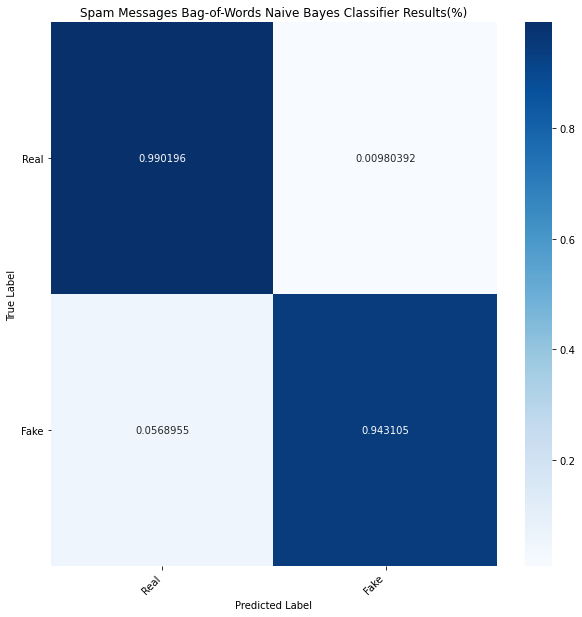

In [116]:
# plot confusion matrix as a heatmap
con_mat(df_cm, title='Spam Messages Bag-of-Words Naive Bayes Classifier Results', colors='Blues', percentage=False)
# plot percentage values
con_mat(df_cm, title='Spam Messages Bag-of-Words Naive Bayes Classifier Results', colors='Blues', percentage=True)

The second model is a logistic regression classifier. The accuracy is almost 99%. A look at the confusion matrix suggests that the false positives have definitely gone down from the Naive Bayes case from 5% to almost 0.7%. The false negatives have gone slightly up, from 0.9% to 1.2%. 

In [117]:
## use logistic regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [118]:
## evaluate model using accuracy
accuracy(y_test, y_pred, model_name='Logistic Regression using Bag of Words')

Accuracy of Logistic Regression using Bag of Words: 0.989882417281925


In [119]:
## evaluate using confusion matrix
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# convert to numpy matrix
val = np.mat(cm)
# class labels (1: FAKE, 0: REAL)
# create a dataframe from the 
df_cm=pd.DataFrame(val, index=LABELS, columns=LABELS)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       Real  Fake
Real  2015    25
Fake    12  1605


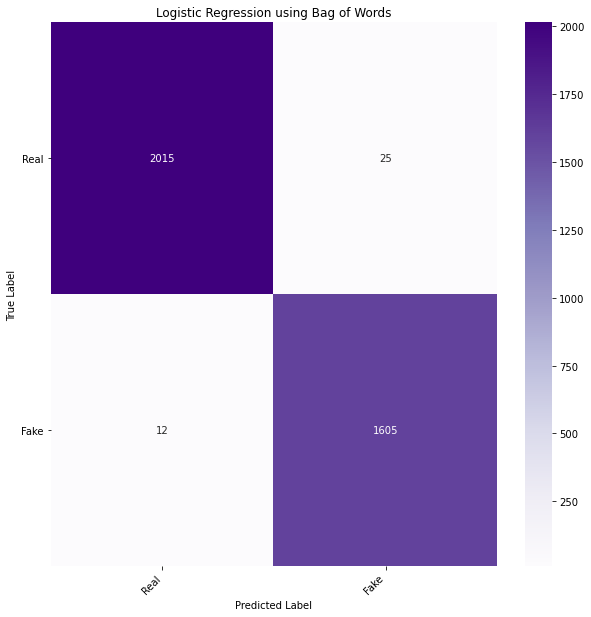

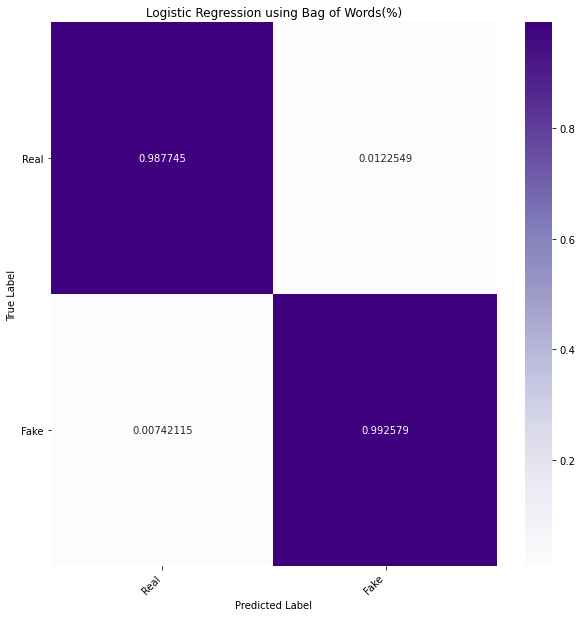

In [120]:
# plot confusion matrix as a heatmap
con_mat(df_cm, title='Logistic Regression using Bag of Words', colors='Purples', percentage=False)
# plot percentages
con_mat(df_cm, title='Logistic Regression using Bag of Words', colors='Purples', percentage=True)

The third model is a passive aggressive classifier. The model gives a prediction accuracy of 99%, and the best confusion matrix score so far. The false negatives and false positives are both around 0.7%.

In [132]:
## using a passive aggressive classifier algorithm
pa_model = PassiveAggressiveClassifier()
pa_model.fit(X_train, y_train)
y_pred = pa_model.predict(X_test)

In [133]:
## evaluate model using accuracy
accuracy(y_test, y_pred, model_name='Passive Aggressive Classifier using Bag of Words')

Accuracy of Passive Aggressive Classifier using Bag of Words: 0.9923434509160514


In [134]:
## evaluate using confusion matrix
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# convert to numpy matrix
val = np.mat(cm)
# class labels (1: FAKE, 0: REAL)
# create a dataframe from the 
df_cm=pd.DataFrame(val, index=LABELS, columns=LABELS)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       Real  Fake
Real  2024    16
Fake    12  1605


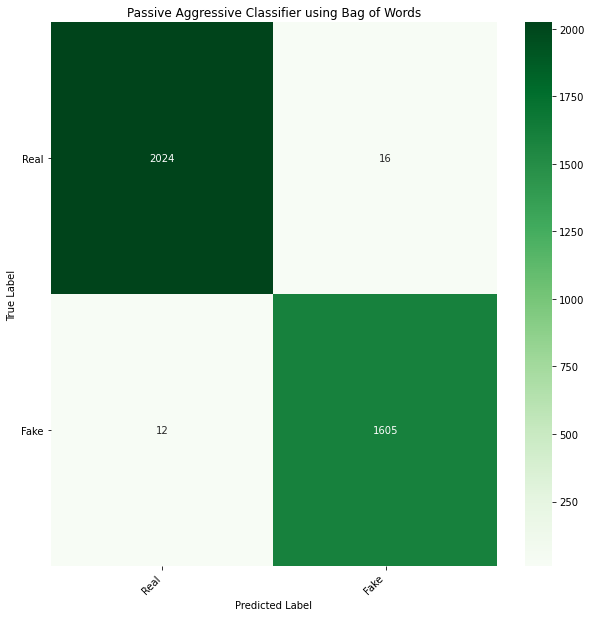

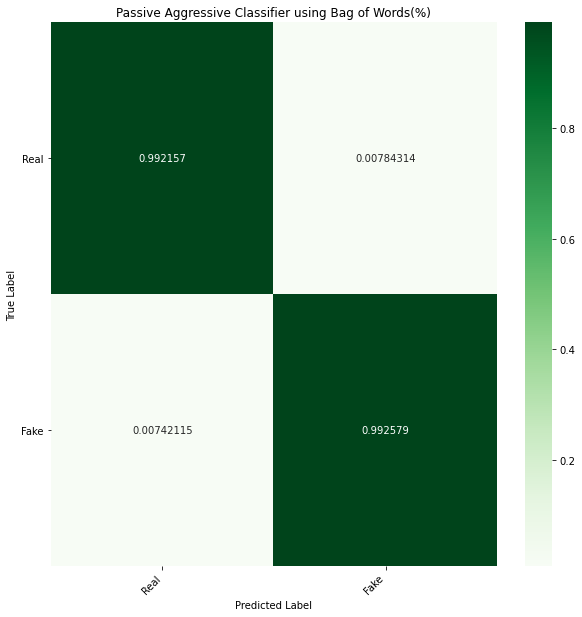

In [135]:
# plot confusion matrix as a heatmap
con_mat(df_cm, title='Passive Aggressive Classifier using Bag of Words', colors='Greens', percentage=False)
# plot percentages
con_mat(df_cm, title='Passive Aggressive Classifier using Bag of Words', colors='Greens', percentage=True)

The next model is a SVM classifier. SVM classifiers are a popular choice in text categorization. However, the model can have a long training time when training data is large. This was the case during this training as well. The accuracy of the model was almost 99%. Looking at the confusion matrix, the model performed well, and performance was similar to the logisitc regression classifier. 

In [127]:
## fit a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [128]:
## evaluate model using accuracy
accuracy(y_test, y_pred, model_name='SVM Classifier using Bag of Words')

Accuracy of SVM Classifier using Bag of Words: 0.9893355209187858


In [129]:
## evaluate using confusion matrix
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# convert to numpy matrix
val = np.mat(cm)
# class labels (1: FAKE, 0: REAL)
# create a dataframe from the 
df_cm=pd.DataFrame(val, index=LABELS, columns=LABELS)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       Real  Fake
Real  2009    31
Fake     8  1609


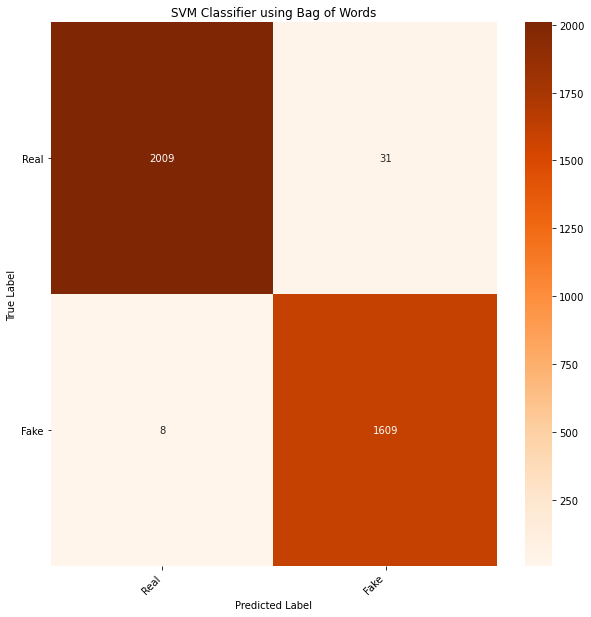

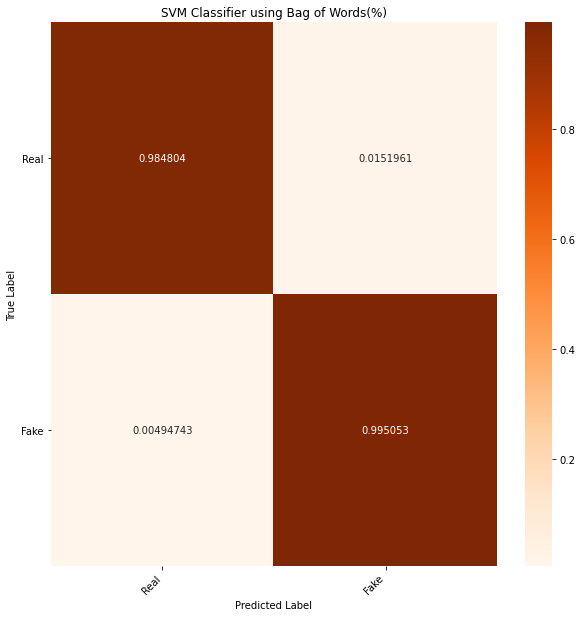

In [130]:
# plot confusion matrix as a heatmap
con_mat(df_cm, title='SVM Classifier using Bag of Words', colors='Oranges', percentage=False)
# plot percentages
con_mat(df_cm, title='SVM Classifier using Bag of Words', colors='Oranges', percentage=True)

The final model is a random forest classifier. Ensemble techniques are a very popular choice in machine learning, and for the right reasons too, since it is robust and can make better predictions than a single model. The model gives an accuracy of 99.3%, and the lowest false positive rate. The false negative rate is also 0.78%.

In [145]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [146]:
## evaluate model using accuracy
accuracy(y_test, y_pred, model_name='Random Forest Classifier using Bag of Words')

Accuracy of Random Forest Classifier using Bag of Words: 0.9937106918238994


In [147]:
## evaluate using confusion matrix
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# convert to numpy matrix
val = np.mat(cm)
# class labels (1: FAKE, 0: REAL)
# create a dataframe from the 
df_cm=pd.DataFrame(val, index=LABELS, columns=LABELS)
print("Confusion Matrix: \n", df_cm)

Confusion Matrix: 
       Real  Fake
Real  2024    16
Fake     7  1610


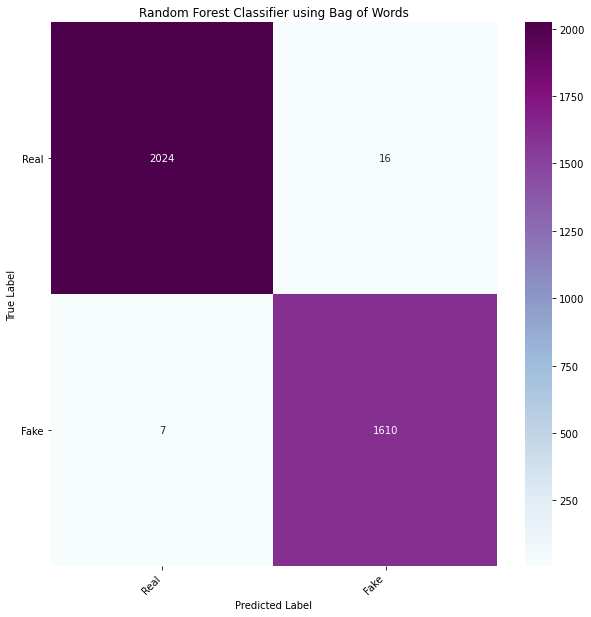

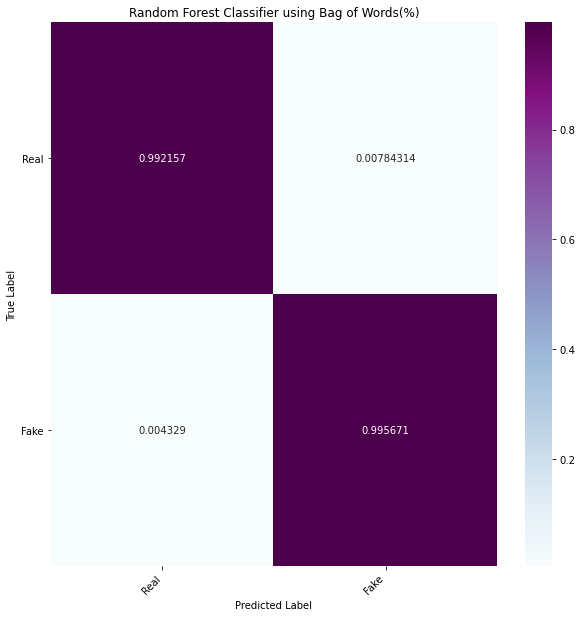

In [148]:
# plot confusion matrix as a heatmap
con_mat(df_cm, title='Random Forest Classifier using Bag of Words', colors='BuPu', percentage=False)
# plot percentages
con_mat(df_cm, title='Random Forest Classifier using Bag of Words', colors='BuPu', percentage=True)

### Conclusion
All models performed quite well 